# Map-based simulation for absolute pointing offset with HWP

## Here, we introduce how to assess pointing systematics with HWP by the map-based simulation in the case of a single detector on the boresight.


In [37]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields
import sbm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the cross-link on the boresight detector

## Input map: CMB (r=0), Gaussian beam smoothing (1 deg for FWHM)


In [38]:
# Load single detector map
scan_field = ScanFields.load_det("boresight/boresight")
fiducial_map = hp.read_map("../maps/cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6

fwhm = np.deg2rad(1.0)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.npix2nside(len(input_map[0]))
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

# Set a pointing systematics parameter

$\rho$ (`rho`): a magnitude of pointing offset of a dtector.

$\chi$ (`chi`): a pointing offset direction

Here, we set $(\rho, \chi)=(1,0)$ arcmin differential pointing.


In [39]:
I = input_map[0]
P = input_map[1] + 1j*input_map[2]
dI = hp.alm2map_der1(hp.map2alm(input_map[0]), nside=nside)
dQ = hp.alm2map_der1(hp.map2alm(input_map[1]), nside=nside)
dU = hp.alm2map_der1(hp.map2alm(input_map[2]), nside=nside)

eth_I = dI[2] - dI[1]*1j
eth_P = dQ[2] + dU[1] - (dQ[1] - dU[2])*1j
o_eth_P = dQ[2] - dU[1] + 1j*(dQ[1] + dU[2])

rho_T = np.deg2rad(1/60)
chi_T = np.deg2rad(0)

mdim = 3
signal_field = sbm.SignalFields.abs_pointing_field(scan_field, mdim, rho_T, chi_T, I, P, eth_I, eth_P, o_eth_P)

# Solve the liner system

Here, we perform the map-making by 3x3 matrix.


In [40]:
output_map = scan_field.map_make(signal_field, only_iqu=True)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 3x3 noise covariant matrix are contaminated by the systematics


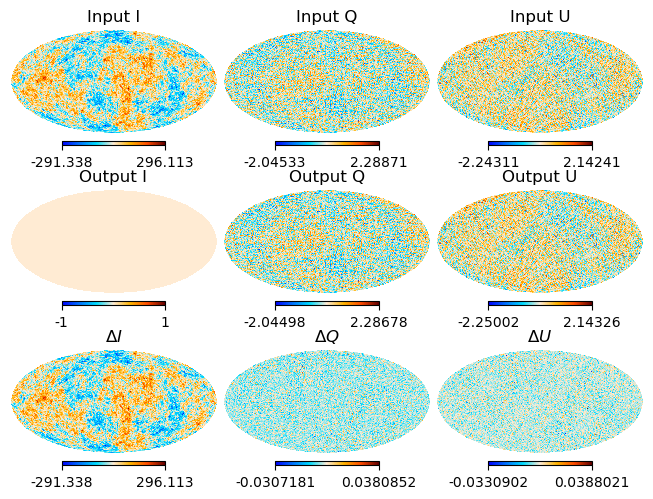

In [41]:
cmap = sbm.get_cmap()
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

# Let's check the power spectra


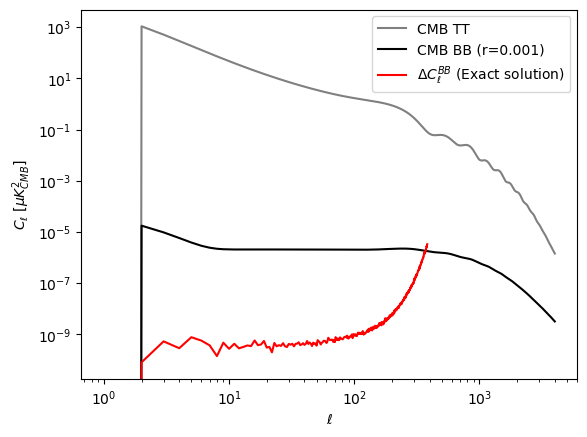

In [42]:
r = 0.001
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();


# Mitigation method

By chapturing $spin$-$\pm$1 component, we can avoid to have tempereture-to-polarization leakage.
To do it, we expand the matrix size 3x3 to 9x9 as below


In [43]:
mdim = 9
signal_field = sbm.SignalFields.abs_pointing_field(scan_field, mdim, rho_T, chi_T, I, P, eth_I, eth_P, o_eth_P)
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

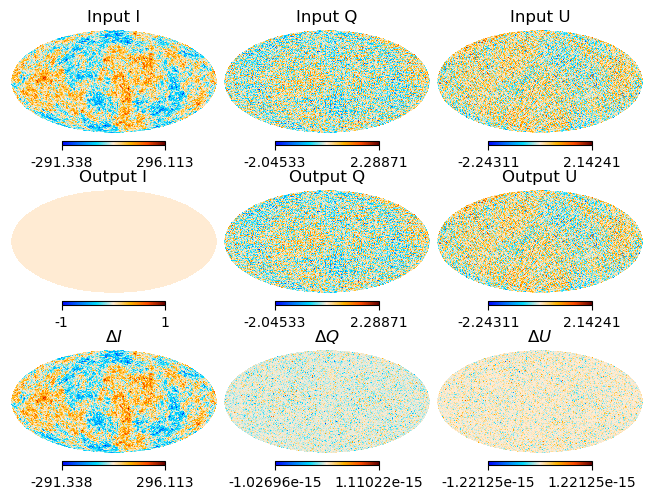

In [44]:
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

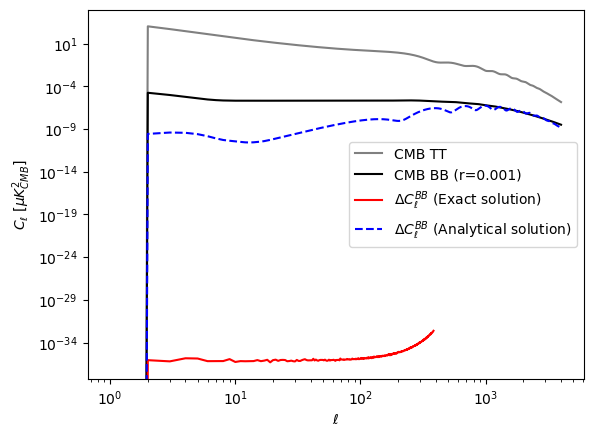

In [45]:
fiducial_cl = sbm.load_fiducial_cl(r)#hp.anafast(fiducial_map)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(scan_field.get_xlink(1,0))**2)
xlink3_mean = np.mean(np.abs(scan_field.get_xlink(3,0))**2)

ana = 1/4*(xlink1_mean + xlink3_mean) * fiducial_cl[1] * rho_T**2 * ell**2

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution
plt.plot(ana, "--", label="$\Delta C_\ell^{BB}$ (Analytical solution)", color="blue")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();